In [1]:
! pip install -q efficientnet

In [2]:
import os
import json
import sys
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_addons as tfa

import albumentations

import re
import itertools
import joblib
import math

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Input, MaxPooling2D, BatchNormalization,
                                    GlobalAveragePooling2D, Dense, Conv2D,
                                    Dropout, Flatten, Activation, ZeroPadding2D,
                                    Add)

from albumentations import (Compose, RandomBrightness, Normalize,
                            HueSaturationValue, RandomContrast, 
                            HorizontalFlip,Rotate, CLAHE)

from tensorflow.keras import activations
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K

from keras.models import load_model
from keras.utils import plot_model
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import efficientnet.tfkeras as efn

from PIL import Image
from functools import partial
from kaggle_datasets import KaggleDatasets

import matplotlib.pyplot as plt
%matplotlib inline
import gc
import tempfile

In [3]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('ranzcr-clip-catheter-line-classification')
GCS_DS_PATH

'gs://kds-949d43c601e22d0950846282da35581e051ced021a05ab31e0be609a'

In [4]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [5]:
IMAGE_SIZE = [528,528]
HEIGHT,WIDTH = IMAGE_SIZE[0],IMAGE_SIZE[1]
CHANNELS = 3

AUTO = tf.data.experimental.AUTOTUNE

FILENAMES = tf.io.gfile.glob(GCS_DS_PATH + '/train_tfrecords/*.tfrec')
TRAINING_FILENAMES = FILENAMES[:-2]
VALIDATION_FILENAMES = FILENAMES[-2:]
TEST_FILENAMES = tf.io.gfile.glob(GCS_DS_PATH + '/test_tfrecords/*.tfrec')

In [6]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, [*IMAGE_SIZE])
    return image


def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "StudyInstanceUID"           : tf.io.FixedLenFeature([], tf.string),
        "image"                      : tf.io.FixedLenFeature([], tf.string),
        "ETT - Abnormal"             : tf.io.FixedLenFeature([], tf.int64), 
        "ETT - Borderline"           : tf.io.FixedLenFeature([], tf.int64), 
        "ETT - Normal"               : tf.io.FixedLenFeature([], tf.int64), 
        "NGT - Abnormal"             : tf.io.FixedLenFeature([], tf.int64), 
        "NGT - Borderline"           : tf.io.FixedLenFeature([], tf.int64), 
        "NGT - Incompletely Imaged"  : tf.io.FixedLenFeature([], tf.int64), 
        "NGT - Normal"               : tf.io.FixedLenFeature([], tf.int64), 
        "CVC - Abnormal"             : tf.io.FixedLenFeature([], tf.int64), 
        "CVC - Borderline"           : tf.io.FixedLenFeature([], tf.int64), 
        "CVC - Normal"               : tf.io.FixedLenFeature([], tf.int64), 
        "Swan Ganz Catheter Present" : tf.io.FixedLenFeature([], tf.int64),
    }
    
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = [example['ETT - Abnormal'],
                 example['ETT - Borderline'],
                 example['ETT - Normal'],
                 example['NGT - Abnormal'],
                 example['NGT - Borderline'],
                 example['NGT - Incompletely Imaged'],
                 example['NGT - Normal'],
                 example['CVC - Abnormal'],
                 example['CVC - Borderline'],
                 example['CVC - Normal'],
                 example['Swan Ganz Catheter Present']]
    label = [tf.cast(i,tf.float32) for i in label]
    return image, label


def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "StudyInstanceUID"           : tf.io.FixedLenFeature([], tf.string),
        "image"                      : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['StudyInstanceUID']
    return image, idnum

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) 
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    return dataset

In [7]:
@tf.function
def augment(image,label):
    
    img_size = [528,528]
        
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    '''if tf.random.uniform([], 0, 1.0, dtype = tf.float32) > 0.75:
        image = tf.image.transpose(image)

    probablity_rotation = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    if probablity_rotation > 0.75:
        image = tf.image.rot90(image, k = 3)
    elif probablity_rotation > 0.5:
        image = tf.image.rot90(image, k = 2)
    elif probablity_rotation > 0.25:
        image = tf.image.rot90(image, k = 1)'''

    if tf.random.uniform([], 0, 1.0, dtype = tf.float32) >= 0.4:
        image = tf.image.random_saturation(image, lower = 0.8, upper = 1.2)
    if tf.random.uniform([], 0, 1.0, dtype = tf.float32) >= 0.4:
        image = tf.image.random_contrast(image, lower = 0.8, upper = 1.2)
    if tf.random.uniform([], 0, 1.0, dtype = tf.float32) >= 0.4:
        image = tf.image.random_brightness(image, max_delta = 0.1)

    probability_cropping = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    if probability_cropping > 0.7:
        if probability_cropping > 0.9:
            image = tf.image.central_crop(image, central_fraction = 0.7)
        elif probability_cropping > 0.8:
            image = tf.image.central_crop(image, central_fraction = 0.8)
        else:
            image = tf.image.central_crop(image, central_fraction = 0.9)
            
    elif probability_cropping > 0.5:
        crop_size = tf.random.uniform([], int(img_size[0] * 0.8), img_size[0], dtype = tf.int32)
        image = tf.image.random_crop(image, size = [crop_size, crop_size, 3])

    image = tf.image.resize(image, size = img_size)
    image = tf.reshape(image, [*img_size, 3])
        
    return image,label

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() 
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.map(augment, num_parallel_calls=AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.map(augment, num_parallel_calls=AUTO)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES,
                                                                                           NUM_VALIDATION_IMAGES,
                                                                                           NUM_TEST_IMAGES))

Dataset: 26334 training images, 3762 validation images, 3584 unlabeled test images


In [8]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

train_ds = get_training_dataset()
valid_ds = get_validation_dataset()
test_ds = get_test_dataset()

print("Training:", train_ds)
print("Validation:",valid_ds)
print("Test:", test_ds)

Training: <PrefetchDataset shapes: ((None, 528, 528, 3), (None, 11)), types: (tf.float32, tf.float32)>
Validation: <PrefetchDataset shapes: ((None, 528, 528, 3), (None, 11)), types: (tf.float32, tf.float32)>
Test: <PrefetchDataset shapes: ((None, 528, 528, 3), (None,)), types: (tf.float32, tf.string)>


In [9]:
def create_model():
    
    #inputs = tf.keras.Input(shape=(600,600,3))
    
    model = tf.keras.Sequential()
    base_model = efn.EfficientNetB6(
            input_shape=(528,528,3),
            weights='imagenet',
            include_top=False)
    
    for layer in base_model.layers:
        if not isinstance(layer,BatchNormalization):
            layer.trainable = True           
    
    '''x = tf.keras.applications.InceptionV3(
            input_shape=(512,512,3),
            weights='imagenet',
            include_top=False)(inputs)'''
    
    model.add(base_model)
    model.add(tf.keras.layers.GaussianNoise(1))
    model.add(GlobalAveragePooling2D())
    #model.add(Dropout(0.5))
    
    '''model.add(Dense(512,activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
    model.add(BatchNormalization())
    model.add(Dense(256,activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128,activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
    model.add(BatchNormalization())'''
    
    model.add(Dense(11,activation="sigmoid"))

    return model

In [10]:
model = create_model()
model.summary()

165527552/165527152 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 17, 17, 2304)      40960136  
_________________________________________________________________
gaussian_noise (GaussianNois (None, 17, 17, 2304)      0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 11)                25355     
Total params: 40,985,491
Trainable params: 40,761,059
Non-trainable params: 224,432
_________________________________________________________________


In [11]:
def sigmoid_focal_crossentropy(y_true, y_pred, alpha=0.25, gamma=2.0):
    
    def smooth(y, smooth_factor):
        assert len(y.shape) == 2
        y *= 1 - smooth_factor
        y += smooth_factor / y.shape[1]
        return y
    
    #label smoothing factor
    FACTOR = 0.1
    alpha_factor = 1.0
    modulating_factor = 1.0

    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.convert_to_tensor(smooth(y_true, FACTOR), dtype=y_pred.dtype)

    ce = K.binary_crossentropy(y_true, y_pred, from_logits=False)

    p_t = (y_true * y_pred) + ((1 - y_true) * (1 - y_pred))
    
    alpha = tf.convert_to_tensor(alpha, dtype=K.floatx())
    alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)

    gamma = tf.convert_to_tensor(gamma, dtype=K.floatx())
    modulating_factor = tf.pow((1.0 - p_t), gamma)

    return tf.reduce_sum(alpha_factor * modulating_factor * ce, axis=-1)

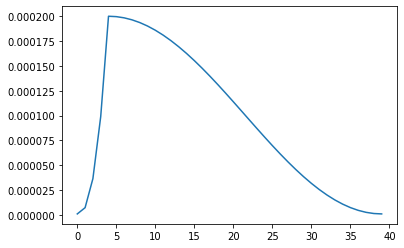

In [12]:
EPOCHS=40
def lrfn(epoch, bs=BATCH_SIZE, epochs=40):

    LR_START = 1e-6
    LR_MAX = 2e-4
    LR_FINAL = 1e-6
    LR_RAMPUP_EPOCHS = 4
    LR_SUSTAIN_EPOCHS = 0
    DECAY_EPOCHS = epochs  - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
    LR_EXP_DECAY = (LR_FINAL / LR_MAX) ** (1 / (EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1))

    if epoch < LR_RAMPUP_EPOCHS:
        lr = LR_START + (LR_MAX + LR_START) * (epoch / LR_RAMPUP_EPOCHS) ** 2.5
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        epoch_diff = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        decay_factor = (epoch_diff / DECAY_EPOCHS) * math.pi
        decay_factor= (tf.math.cos(decay_factor).numpy() + 1) / 2        
        lr = LR_FINAL + (LR_MAX - LR_FINAL) * decay_factor

    return lr

import matplotlib.pyplot as plt  
rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)

In [13]:
def create_callbacks(model_save_path):
    
    
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)
    
    cpk_path = f'{model_save_path}/model.h5'

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=cpk_path,
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    reducelr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_auc',
        mode='max',
        factor=0.7,
        patience=5,
        verbose=1
    )
    
    #lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=1)

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=10, 
        verbose=1
    )
    
    callbacks = [checkpoint,reducelr, earlystop]
    return callbacks

In [14]:
EPOCHS= 40
VERBOSE =1
MODEL_PATH = '.'
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES//(BATCH_SIZE)

with strategy.scope():
    
    model = create_model()
    
    opt = keras.optimizers.Adam()
    #opt = tfa.optimizers.RectifiedAdam(lr=1e-3,total_steps=50,
                                       #warmup_proportion=0.2,min_lr=1e-4)
    #opt = tfa.optimizers.MovingAverage(opt)    
    
    #loss=tfa.losses.SigmoidFocalCrossEntropy()
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                  optimizer=opt, 
                 metrics = [tf.keras.metrics.AUC(name='auc',multi_label=True)])
    
    callbacks = create_callbacks(MODEL_PATH)
    
    history = model.fit(train_ds, 
                        epochs=EPOCHS,
                        callbacks=callbacks,
                        validation_data = valid_ds,
                        steps_per_epoch = STEPS_PER_EPOCH,
                        verbose=VERBOSE)    

Epoch 1/40
205/205 [==============================] - 385s 1s/step - loss: 0.2786 - auc: 0.7154 - val_loss: 0.3618 - val_auc: 0.7409

Epoch 00001: val_auc improved from -inf to 0.74092, saving model to ./model.h5
Epoch 2/40
205/205 [==============================] - 201s 982ms/step - loss: 0.2007 - auc: 0.8318 - val_loss: 0.2291 - val_auc: 0.8416

Epoch 00002: val_auc improved from 0.74092 to 0.84159, saving model to ./model.h5
Epoch 3/40
205/205 [==============================] - 201s 982ms/step - loss: 0.1764 - auc: 0.8865 - val_loss: 0.2069 - val_auc: 0.8843

Epoch 00003: val_auc improved from 0.84159 to 0.88433, saving model to ./model.h5
Epoch 4/40
205/205 [==============================] - 202s 986ms/step - loss: 0.1628 - auc: 0.9087 - val_loss: 0.1991 - val_auc: 0.8870

Epoch 00004: val_auc improved from 0.88433 to 0.88701, saving model to ./model.h5
Epoch 5/40
205/205 [==============================] - 201s 983ms/step - loss: 0.1547 - auc: 0.9105 - val_loss: 0.1971 - val_auc: 0

In [20]:
model_name = "EfficientNetB6_FineTuned.h5"
model.save(model_name)